# Multiple crops from a single image

This notebook demonstrates how to obtain multiple crops from a single image.
This technique uses the operator `fn.warp_affine` to obtain the crops and the operator `fn.per_frame` to trigger expansion of single image into a sequence.

Two techniques are presented. Both have the limitation that the output crops need to be of the same size.
In the first example, the source patches are of the same size.
In the second example, the source patches have a variable size, but are then scaled to fill a fixed-size image.

Let's start with importing DALI and other libraries and writing a couple of functions that diplay the results.

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali as dali
import nvidia.dali.fn as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import os


def show(images, rows, columns):
    n = len(images)

    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=(16, rows * 3))
    plt.suptitle(None)
    gs = gridspec.GridSpec(rows, columns)
    for i in range(n):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        plt.title("")
        if images[i] is None:
            continue
        img = np.array(images[i])
        plt.imshow(img)


def show_seqs(sequences):
    sequences = [np.array(seq) for seq in sequences]
    max_len = 0
    for seq in sequences:
        max_len = max(max_len, seq.shape[0])

    if max_len == 0:
        return

    images = []

    for seq in sequences:
        seq_len = seq.shape[0]
        for i in range(seq_len):
            images.append(seq[i])
        for i in range(seq_len, max_len):
            images.append(None)

    show(images, len(sequences), max_len)


dir = os.path.join(os.environ["DALI_EXTRA_PATH"], "db", "single", "jpeg")

## Equal-sized crop pipeline

In the first example, the cropping window (both source and destination) has a fixed size. The cropping window has integer coordinates and the warping is done with nearest neighbor interpolation.
The size of the cropping window is random (but equal for all crops taken from a given sample).

The `fn.warp_affine` operator broadcasts the input image to multiple frames when it recognizes that its other arguments (in this case, the matrix) are defined per-frame.

In [2]:
@pipeline_def(
    batch_size=3,
    num_threads=4,
    device_id=0,
    experimental_exec_dynamic=True,  # allows to manipulate shapes of GPU images in a CPU op
    seed=42,
)
def fixed_size_crops():
    files, labels = fn.readers.file(file_root=dir, random_shuffle=True)
    img = fn.decoders.image(files, device="mixed")
    shape = fn.shapes(img, device="cpu", dtype=dali.types.INT32)
    h, w = shape[0], shape[1]
    # this is fixed for all crops taken from given image
    crop_w = fn.random.uniform(
        range=fn.stack(w / 4, w / 2), dtype=dali.types.INT32
    )
    crop_h = fn.random.uniform(
        range=fn.stack(h / 4, h / 2), dtype=dali.types.INT32
    )
    # the number of crops is random, from 1 to 5
    num_crops = fn.random.uniform(range=(1, 5), dtype=dali.types.INT32)
    # the crop origin is selected so that the crop doesn't go outside the image
    crop_x_range = fn.cast(
        fn.stack(0, w - crop_w), dtype=dali.types.FLOAT
    )  # stacking different types
    crop_y_range = fn.cast(fn.stack(0, h - crop_h), dtype=dali.types.FLOAT)
    crop_param_shape = num_crops[dali.newaxis]
    crop_x = fn.random.uniform(
        shape=crop_param_shape, range=crop_x_range, dtype=dali.types.INT32
    )
    crop_y = fn.random.uniform(
        shape=crop_param_shape, range=crop_y_range, dtype=dali.types.INT32
    )

    # these are in XY order as opposed to tensor shape, which is HW
    crop_start = fn.stack(crop_x, crop_y, axis=1)
    crop_size = fn.stack(crop_w, crop_h, axis=0)[dali.newaxis]
    crop_end = crop_start + crop_size

    crop_start = fn.per_frame(
        crop_start + 0.0
    )  # convert to float and mark outermost dimension as"frame"
    crop_end = fn.per_frame(crop_end + 0.0)
    crop_size = fn.per_frame(crop_size + 0.0)

    # create a "crop" transform matrix
    # - the "from" coordinates are the coordinates within the source image
    # - the "to" coordinates are in the destination image
    mtx = fn.transforms.crop(
        from_start=crop_start, from_end=crop_end, to_start=0.0, to_end=crop_size
    )

    crops = fn.warp_affine(
        img,
        mtx,
        size=fn.stack(crop_h, crop_w),
        interp_type=dali.types.INTERP_NN,
        inverse_map=False,
    )

    return crops


fixed_crop_pipe = fixed_size_crops()
fixed_crop_pipe.build()

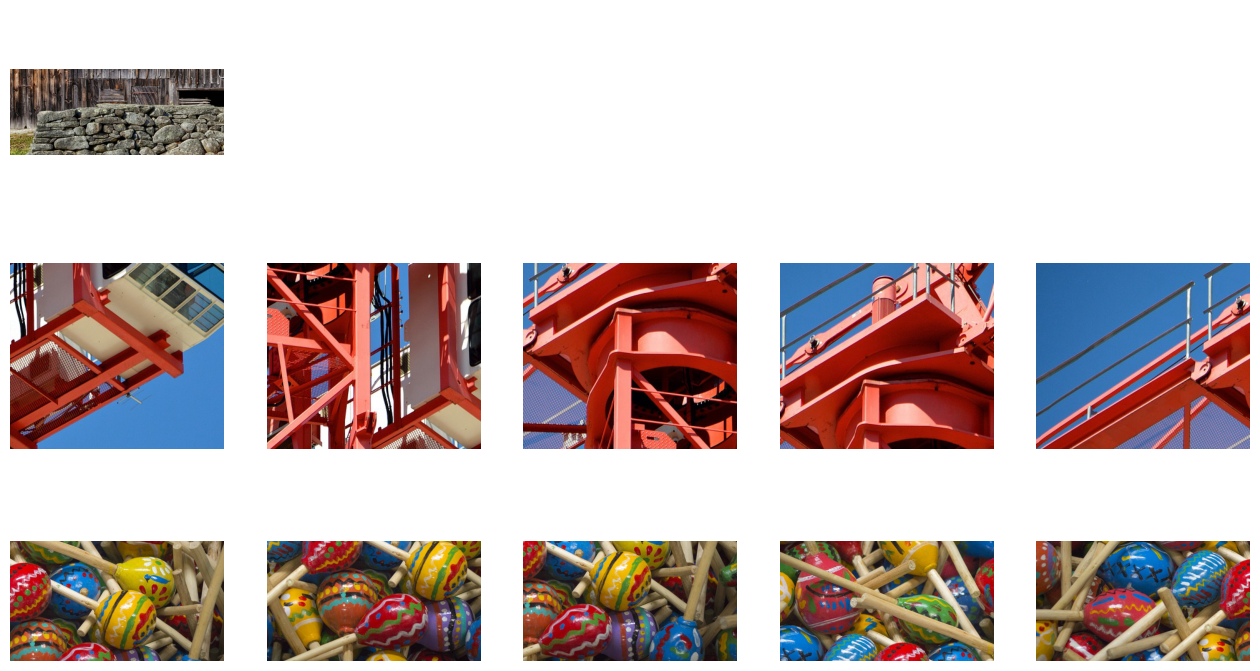

In [3]:
(crops,) = fixed_crop_pipe.run()
show_seqs(crops.as_cpu())

## Variable-sized crop pipeline

In the second example, we take multiple variable-sized crops from an image, but resize them to a common size. The cropping and resizing are fused in one `fn.warp_affine` operation. The crop coordinates and size are floating-point values and the warping uses bilinear interpolation.

The fused crop and resize matrix is just as easy to obtain with `fn.transforms.crop`.


In [4]:
@pipeline_def(
    batch_size=3,
    num_threads=4,
    device_id=0,
    experimental_exec_dynamic=True,  # allows to manipulate shapes of GPU images in a CPU op
    seed=123,
)
def var_sized_resized_crops():
    files, labels = fn.readers.file(file_root=dir, random_shuffle=True)
    img = fn.decoders.image(files, device="mixed")
    shape = fn.shapes(img, device="cpu", dtype=dali.types.INT32)
    h, w = shape[0], shape[1]
    # the number of crops is random, from 1 to 5
    num_crops = fn.random.uniform(range=(1, 5), dtype=dali.types.INT32)
    # the crop origin is selected so that the crop doesn't go outside the image
    crop_param_shape = fn.stack(num_crops, 2)
    input_size_wh = fn.stack(w, h)
    crop_size = fn.random.uniform(shape=crop_param_shape, range=(0.25, 0.5))
    crop_start = fn.random.uniform(shape=crop_param_shape, range=(0, 1))
    crop_start *= 1 - crop_size

    output_size = dali.types.Constant([64.0, 64.0])

    crop_end = crop_start + crop_size

    crop_start = fn.per_frame(
        crop_start * input_size_wh + 0.0
    )  # convert to float and mark outermost dimension as"frame"
    crop_end = fn.per_frame(crop_end * input_size_wh + 0.0)
    crop_size = fn.per_frame(crop_size * input_size_wh + 0.0)

    mtx = fn.transforms.crop(
        from_start=crop_start, from_end=crop_end, to_start=0, to_end=output_size
    )

    crops = fn.warp_affine(img, mtx, size=output_size, inverse_map=False)

    return crops


var_crop_pipe = var_sized_resized_crops()
var_crop_pipe.build()

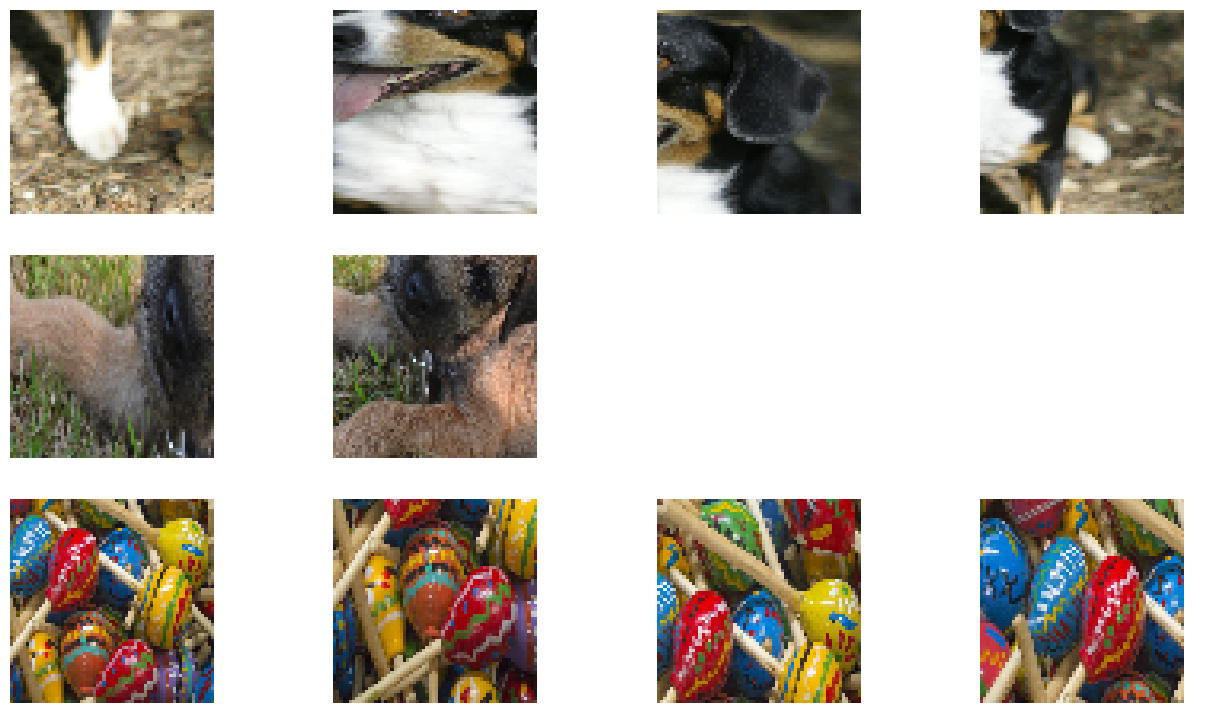

In [5]:
crops, *tail = var_crop_pipe.run()
print(*tail)
show_seqs(crops.as_cpu())